In [1]:
import matplotlib.pyplot as plt
import os
import torch
from models import ASTModel
# download pretrained model in this directory
os.environ['TORCH_HOME'] = '../pretrained_models'
# assume each input spectrogram has 100 time frames
input_tdim = 100
# assume the task has 527 classes
label_dim = 527
# create a pseudo input: a batch of 10 spectrogram, each with 100 time frames and 128 frequency bins
test_input = torch.rand([10, input_tdim, 128])


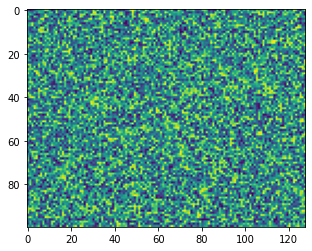

In [3]:
plt.imshow(test_input[0])

In [4]:
cwd = os.getcwd()
print(cwd)

/ocean/projects/iri120008p/billyli/ast/src


In [5]:
from os import walk
print(os.path.dirname('./'))
os.getcwd(path)

f = []
for (dirpath, dirnames, filenames) in walk(os.path.dirname('../../pretrained_models/')):
    f.extend(filenames)
    break
print(f)

.


NameError: name 'path' is not defined

In [6]:
os.path.exists('/ocean/projects/iri120008p/billyli/ast/pretrained_models/audioset_10_10_0.4593.pth')

True

In [7]:
# create an AST model
ast_mdl = ASTModel(label_dim=label_dim, input_tdim=input_tdim, imagenet_pretrain=True, audioset_pretrain=True)
test_output = ast_mdl(test_input)
# output should be in shape [10, 527], i.e., 10 samples, each with prediction of 527 classes.
print(test_output.shape)

---------------AST Model Summary---------------
ImageNet pretraining: True, AudioSet pretraining: True
I got here!
frequncey stride=10, time stride=10
number of patches=108
torch.Size([10, 527])


In [10]:
print(test_output)

tensor([[-1.0752, -0.8514,  0.6243,  ...,  0.2581, -0.1125, -0.2531],
        [-1.0789, -0.8482,  0.5905,  ...,  0.2280, -0.1780, -0.3016],
        [-1.1520, -0.7946,  0.4990,  ...,  0.1910, -0.1334, -0.3769],
        ...,
        [-1.0479, -0.8515,  0.6453,  ...,  0.2801, -0.1839, -0.3540],
        [-1.0681, -0.7954,  0.6167,  ...,  0.2314, -0.0448, -0.2950],
        [-1.1177, -0.8490,  0.5643,  ...,  0.2917, -0.1350, -0.3613]],
       grad_fn=<AddmmBackward0>)
